In [67]:
# ! pip install imbalanced-learn
# ! pip install --force-reinstall 'scikit-learn==0.19.2' 
# ! pip install pickle-mixin
# ! pip install --force-reinstall 'scikit-learn==0.19.2' 

In [68]:
import math
import json
import pickle
import numpy as np
import pandas as pd
import coremltools as ct
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict

from sklearn.tree import _tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [69]:
STAGE = {
    'In Bed': 0,
    'Awake': 1,
    'Asleep': 2,
    'REM': 3,
    'Core': 4,
    'Deep': 5,
    'Unknown': 6
}

In [70]:
def load_json(path: str) -> dict:
    with open(path, 'r') as file:
        return json.load(file)

def parse_time(time: str) -> datetime:
    return datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

def to_min(cur_time: datetime, start_time: datetime) -> int:
    return int((cur_time - start_time).total_seconds()//60)

def process_sleep_data(sleep_data: dict) -> dict:
    stages_by_day = defaultdict(dict)

    for data in sleep_data:
        if data['stage'] in ['Awake', 'REM', 'Core', 'Deep']:
            start_time = parse_time(data['start_time'])
            end_time = parse_time(data['end_time'])
            day = end_time.strftime('%Y-%m-%d')

            if not day in stages_by_day:
                stages_by_day[day]['stages'] = list()
                
            stages_by_day[day]['stages'].append({
                'start_time': start_time,
                'end_time': end_time,
                'stage': STAGE[data['stage']]
            })

    for date, data in stages_by_day.items():
        stages_by_day[date]['stages'] = sorted(data['stages'], key=lambda x: x['start_time'])
        stages_by_day[date]['start_time'] = stages_by_day[date]['stages'][0]['start_time']
        stages_by_day[date]['end_time'] = stages_by_day[date]['stages'][-1]['end_time']
        stages_by_day[date]['day_of_week'] = stages_by_day[date]['start_time'].weekday()

    return stages_by_day

def post_process(stage_data: dict) -> pd.DataFrame:
    ml_data = list()
    for date, data in stage_data.items():
        for item in data['stages']:

            start_time = to_min(item['start_time'], data['start_time'])
            end_time = to_min(item['end_time'], data['start_time'])
            
            
            for interval in range(start_time, end_time):
                
                time_of_day = (data['start_time'] + timedelta(minutes=interval)).time()
                time_in_min = time_of_day.hour*60 + time_of_day.minute
                
                ml_data.append((
                    date,
                    time_in_min,
                    data['day_of_week'],
                    interval,
                    item['stage']
                ))
    return pd.DataFrame(ml_data, columns=['date', 'start_time', 'day_of_week', 'interval', 'stage'])

In [71]:
data = load_json('./sleepData.json')['sleep_data']

stage_data = process_sleep_data(data)
ml_data = post_process(stage_data)

In [72]:
print(ml_data.head())
ml_data.info()

         date  start_time  day_of_week  interval  stage
0  2024-02-20         113            1         0      4
1  2024-02-20         114            1         1      4
2  2024-02-20         115            1         2      4
3  2024-02-20         116            1         3      4
4  2024-02-20         117            1         4      4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         195008 non-null  object
 1   start_time   195008 non-null  int64 
 2   day_of_week  195008 non-null  int64 
 3   interval     195008 non-null  int64 
 4   stage        195008 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 7.4+ MB


In [73]:
X = np.array(ml_data[['start_time', 'interval', 'day_of_week']].values)
Y = np.array(ml_data['stage'].values)
print(X)
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

[[113   0   1]
 [114   1   1]
 [115   2   1]
 ...
 [889 281   1]
 [890 282   1]
 [891 283   1]]
[4 4 4 ... 4 4 4]


In [74]:
# # import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# # Sample data
# # X_train = np.random.rand(100, 10, 3)  # Example input data (100 samples, 10 timesteps, 3 features)
# # Y_train = np.random.randint(0, 2, size=(100,))  # Example target labels (binary classification)

# # Define the LSTM model
# model = Sequential([
#     LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(units=1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, Y_train, epochs=10, batch_size=32)


In [142]:
model = RandomForestClassifier(random_state=42, verbose=0.25)
model.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0.25,
            warm_start=False)

In [143]:
# Predict on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6385313573662889
Classification Report:
              precision    recall  f1-score   support

          1       0.34      0.25      0.29       988
          3       0.56      0.57      0.57     10769
          4       0.71      0.73      0.72     21835
          5       0.54      0.47      0.50      5410

avg / total       0.63      0.64      0.64     39002



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


174


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


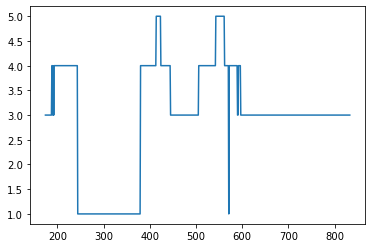

In [201]:
import random
dow = 2
r = random.randint(0, 500)
# r = 100
print(r)
X_sample = [[i+r,i+r, dow] for i in range(11*60)]
Y_sample = model.predict(X_sample)
# print(Y_sample)

[f'{x[0]/60}:{x[0]%60}'  for x in X_sample]

# print(pd.Series(Y_sample).value_counts())
plt.plot([x[0]  for x in X_sample]
, Y_sample)

In [202]:
# Convert the model
coreml_model = ct.converters.sklearn.convert(model, input_features=['start_time', 'interval', 'day_of_week'], output_feature_names='sleep_stage')

# Save the model
coreml_model.save("SleepStageRandomForest.mlmodel")
# coreml_model.save("SleepStageRandomForest.mlpackage")

# Loading the model
# with open('my_random_forest_model.pkl', 'rb') as file:
#     best_model_loaded = pickle.load(file)